ep= 2000  wealth=7120.60  w_L=0.000  w_R=1.000  hits=1499  avg_steps=12.0  avg_unique_x=12.0
ep= 4000  wealth=16640.60  w_L=0.000  w_R=1.000  hits=3499  avg_steps=12.0  avg_unique_x=12.0
ep= 6000  wealth=26160.60  w_L=0.000  w_R=1.000  hits=5499  avg_steps=12.0  avg_unique_x=12.0
ep= 8000  wealth=35680.60  w_L=0.000  w_R=1.000  hits=7499  avg_steps=12.0  avg_unique_x=12.0
ep=10000  wealth=45200.60  w_L=0.000  w_R=1.000  hits=9499  avg_steps=12.0  avg_unique_x=12.0
ep=12000  wealth=54720.60  w_L=0.000  w_R=1.000  hits=11499  avg_steps=12.0  avg_unique_x=12.0
ep=14000  wealth=64240.60  w_L=0.000  w_R=1.000  hits=13499  avg_steps=12.0  avg_unique_x=12.0
ep=16000  wealth=73760.60  w_L=0.000  w_R=1.000  hits=15499  avg_steps=12.0  avg_unique_x=12.0
ep=18000  wealth=83280.60  w_L=0.000  w_R=1.000  hits=17499  avg_steps=12.0  avg_unique_x=12.0
ep=20000  wealth=92800.60  w_L=0.000  w_R=1.000  hits=19499  avg_steps=12.0  avg_unique_x=12.0


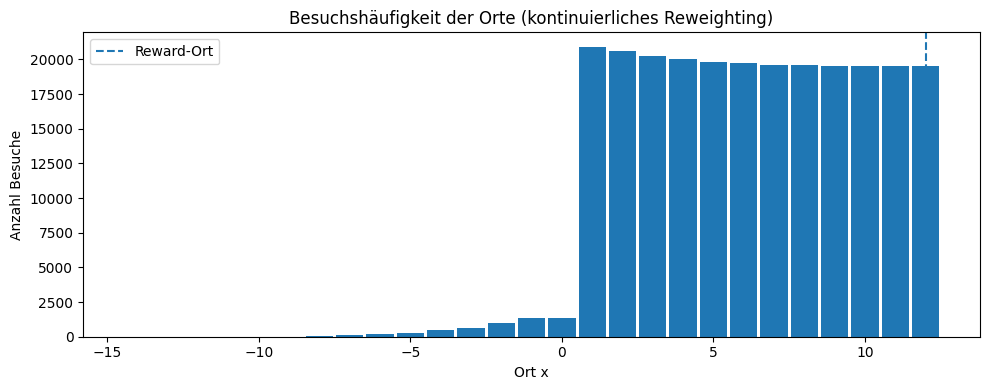

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from capitalselector import CapitalSelectorBuilder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sign(x, eps=1e-12):
    return torch.where(
        x > eps, torch.ones_like(x),
        torch.where(x < -eps, -torch.ones_like(x), torch.zeros_like(x))
    )

class BinomialWorldTorch:
    def __init__(self, x0=0, xmin=-50, xmax=50, x_star=15, R_star=5.0, c_base=0.01, c_move=0.01, device="cpu"):
        self.x0 = x0
        self.x = torch.tensor(float(x0), device=device)
        self.xmin = xmin
        self.xmax = xmax
        self.x_star = x_star
        self.R_star = R_star
        self.c_base = c_base
        self.c_move = c_move

    def reset(self):
        self.x = torch.tensor(float(self.x0), device=self.x.device)

    @torch.no_grad()
    def step(self, u):
        u = torch.clamp(u, min=0.0)
        u = u / u.sum()

        delta = u[1] - u[0]
        dx = sign(delta)

        x_next = torch.clamp(self.x + dx, self.xmin, self.xmax)
        moved = (x_next != self.x).float()
        self.x = x_next

        reward = torch.tensor(self.R_star if int(self.x.item()) == self.x_star else 0.0, device=self.x.device)
        cost = self.c_base + self.c_move * moved
        hit = (reward > 0).float()
        return reward, cost, hit, int(self.x.item())

def run(episodes=20000, max_steps=200):
    world = BinomialWorldTorch(device=device, x_star=12)

    selector = (
        CapitalSelectorBuilder()
        .with_initial_wealth(1.0)
        .with_rebirth_threshold(0.5)
        .with_stats(beta=0.01)
        .with_reweight_eta(0.05)   # langsames, kontinuierliches Lernen
        .with_channels([0, 1])     # links / rechts (nur Dimension)
        .build()
    )

    position_counter = defaultdict(int)
    episode_steps = []
    episode_unique_positions = []
    total_hits = 0

    for ep in range(episodes):
        world.reset()
        visited = set()
        steps = 0

        for t in range(max_steps):
            w = selector.w
            idx = np.random.choice(2, p=w)

            u = torch.tensor([1.0, 0.0], device=device) if idx == 0 else torch.tensor([0.0, 1.0], device=device)
            reward, cost, hit, x = world.step(u)

            steps += 1
            visited.add(x)
            position_counter[x] += 1

            r_vec = np.zeros(2, dtype=float)
            r_vec[idx] = float(reward.item())

            selector.feedback_vector(r_vec, float(cost.item()))

            if hit:
                total_hits += 1
                break

            if selector.wealth < selector.rebirth_threshold:
                break

        episode_steps.append(steps)
        episode_unique_positions.append(len(visited))

        if (ep + 1) % (episodes // 10) == 0:
            print(
                f"ep={ep+1:5d}  "
                f"wealth={selector.wealth:.2f}  "
                f"w_L={selector.w[0]:.3f}  w_R={selector.w[1]:.3f}  "
                f"hits={total_hits}  "
                f"avg_steps={np.mean(episode_steps[-200:]):.1f}  "
                f"avg_unique_x={np.mean(episode_unique_positions[-200:]):.1f}"
            )

    xs = sorted(position_counter.keys())
    counts = [position_counter[x] for x in xs]

    plt.figure(figsize=(10, 4))
    plt.bar(xs, counts, width=0.9)
    plt.axvline(world.x_star, linestyle="--", label="Reward-Ort")  # <- korrekt: x_star
    plt.title("Besuchshäufigkeit der Orte (kontinuierliches Reweighting)")
    plt.xlabel("Ort x")
    plt.ylabel("Anzahl Besuche")
    plt.legend()
    plt.tight_layout()
    plt.show()

run(episodes = 20000, max_steps=20)